#                              Analysis of Bank's Marketing Campaign

In [8]:
%matplotlib inline
import seaborn as sns
from pymatch.Matcher import Matcher
import pandas as pd         
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import imblearn.ensemble
from numpy import mean
from numpy import std
import xgboost
import scipy.stats
from scipy.stats import ks_2samp
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import validation_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import statistics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Data Description

## The data we used for this project comes from marketing campaigns of a Portuguese banking institution.


## The data was accessed from https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

## Below are the input variables and their description as found in the website

## Input variables:
## bank client data:
### 1 - age (numeric)
### 2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
### 3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
### 4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
### 5 - default: has credit in default? (categorical: 'no','yes','unknown')
### 6 - housing: has housing loan? (categorical: 'no','yes','unknown')
### 7 - loan: has personal loan? (categorical: 'no','yes','unknown')
## related with the last contact of the current campaign:
### 8 - contact: contact communication type (categorical: 'cellular','telephone')
### 9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
### 10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
### 11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
## other attributes:
### 12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
### 13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
### 14 - previous: number of contacts performed before this campaign and for this client (numeric)
### 15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
## social and economic context attributes
### 16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
### 17 - cons.price.idx: consumer price index - monthly indicator (numeric)
### 18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
### 19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
### 20 - nr.employed: number of employees - quarterly indicator (numeric)

## Output variable (desired target):
### 21 - y - has the client subscribed a term deposit? (binary: 'yes','no')



In [9]:
url='https://raw.githubusercontent.com/aztgmb/Bank_Marketing_Campaign_Analysis_Segmentation-K-Means-_Classification-RF_XGBoost-/master/bank-additional-full.csv'
bank=pd.read_csv(url, sep=';')
bank=bank.drop(['default','emp.var.rate','cons.price.idx','cons.conf.idx','nr.employed'],axis=1)
warnings.filterwarnings("ignore")
bank

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,euribor3m,y
0,56,housemaid,married,basic.4y,no,no,telephone,may,mon,261,1,999,0,nonexistent,4.857,no
1,57,services,married,high.school,no,no,telephone,may,mon,149,1,999,0,nonexistent,4.857,no
2,37,services,married,high.school,yes,no,telephone,may,mon,226,1,999,0,nonexistent,4.857,no
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,151,1,999,0,nonexistent,4.857,no
4,56,services,married,high.school,no,yes,telephone,may,mon,307,1,999,0,nonexistent,4.857,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,1.028,yes
41184,46,blue-collar,married,professional.course,no,no,cellular,nov,fri,383,1,999,0,nonexistent,1.028,no
41185,56,retired,married,university.degree,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,1.028,no
41186,44,technician,married,professional.course,no,no,cellular,nov,fri,442,1,999,0,nonexistent,1.028,yes


In [10]:
pd.options.mode.chained_assignment = None
bank_graph=bank.loc[(bank['job']!='unknown')&(bank['marital']!='unknown')&(bank['education']!='unknown')
                   &(bank['housing']!='unknown')&(bank['loan']!='unknown')]
bank_ready=bank.loc[(bank['job']!='unknown')&(bank['marital']!='unknown')&(bank['education']!='unknown')
                   &(bank['housing']!='unknown')&(bank['loan']!='unknown')]

le = LabelEncoder()
bank_ready['job']=le.fit_transform(bank_ready["job"])
bank_ready['marital']=le.fit_transform(bank_ready["marital"])
bank_ready['education']=le.fit_transform(bank_ready["education"])
bank_ready['houisng']=le.fit_transform(bank_ready["housing"])
bank_ready['loan']=le.fit_transform(bank_ready["loan"])
bank_ready['contact']=le.fit_transform(bank_ready["contact"])
bank_ready['month']=le.fit_transform(bank_ready["month"])
bank_ready['day_of_week']=le.fit_transform(bank_ready["day_of_week"])
bank_ready['poutcome']=le.fit_transform(bank_ready["poutcome"])
bank_ready['y']=le.fit_transform(bank_ready["y"])
bank_ready=bank_ready.drop(['housing'],axis=1)
bank_graph

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,euribor3m,y
0,56,housemaid,married,basic.4y,no,no,telephone,may,mon,261,1,999,0,nonexistent,4.857,no
1,57,services,married,high.school,no,no,telephone,may,mon,149,1,999,0,nonexistent,4.857,no
2,37,services,married,high.school,yes,no,telephone,may,mon,226,1,999,0,nonexistent,4.857,no
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,151,1,999,0,nonexistent,4.857,no
4,56,services,married,high.school,no,yes,telephone,may,mon,307,1,999,0,nonexistent,4.857,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,1.028,yes
41184,46,blue-collar,married,professional.course,no,no,cellular,nov,fri,383,1,999,0,nonexistent,1.028,no
41185,56,retired,married,university.degree,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,1.028,no
41186,44,technician,married,professional.course,no,no,cellular,nov,fri,442,1,999,0,nonexistent,1.028,yes


# Checking if clients who participated once and twice have similar probability distributions

In [11]:
bank_ready_twice=bank_ready.loc[(bank['poutcome']!='nonexistent')]
bank_ready_twice  
features_twice=bank_ready_twice.iloc[:, np.r_[0:14, 15]]
labels_twice=bank_ready_twice.iloc[:,np.r_[14]]
reg_twice = LogisticRegression().fit(features_twice, labels_twice)
prob_twice=reg_twice.predict_proba(features_twice)[:,1]
prob_twice= pd.DataFrame(prob_twice, columns = ['twice'])
bank_ready_once=bank_ready.loc[(bank['poutcome']=='nonexistent')]
bank_ready_once  
features_once=bank_ready_once.iloc[:, np.r_[0:14, 15]]
labels_once=bank_ready_once.iloc[:,np.r_[14]]
reg_once = LogisticRegression().fit(features_once, labels_once)
prob_once=reg_once.predict_proba(features_once)[:,1]
prob_once= pd.DataFrame(prob_once, columns = ['once'])
#compute Jensen Shannon Divergence
q=prob_twice['twice'].to_numpy()
pr=[]
for i in range (1,1000):
    prep=prob_once.sample(n=5179)
    p=prep['once'].to_numpy()
    m=(p+q)/2
    divergence = (scipy.stats.entropy(p, m) + scipy.stats.entropy(q, m)) / 2
    sqrt11 = np.sqrt(divergence)
    pr.append(sqrt11)
ave=statistics.mean(pr)
print('Jensen Shannon Divergence')
print(ave)

Jensen Shannon Divergence
0.5948105876302808


### We have tested the hypothesis that two probability distribuitons are the same. Acceptance of this hypothesis could allow us to generalize results obtained from analysis of clients who participated in marketing campaign twice. As we can see from the computed value of Jensen Shannon Divergence, two probability distributions are not the same. This means that those two groups of clients are different.

<function matplotlib.pyplot.show(*args, **kw)>

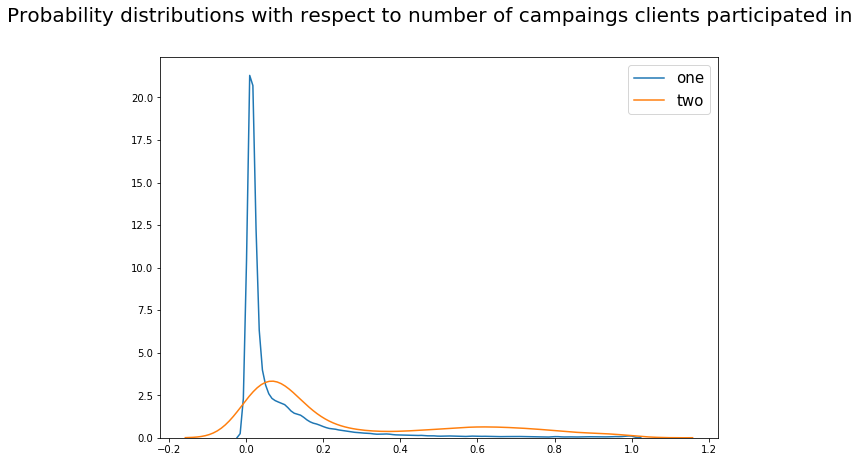

In [12]:
plt.figure(figsize=(10,7))
sns.distplot(prob_once['once'], label='one', hist=False, rug=False)
sns.distplot(prob_twice['twice'], label='two', hist=False, rug=False)
plt.legend(loc='best', prop={'size': 15})
plt.suptitle('Probability distributions with respect to number of campaings clients participated in', fontsize=20)
plt.xlabel('', fontsize=1)
plt.ylabel('', fontsize=1)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

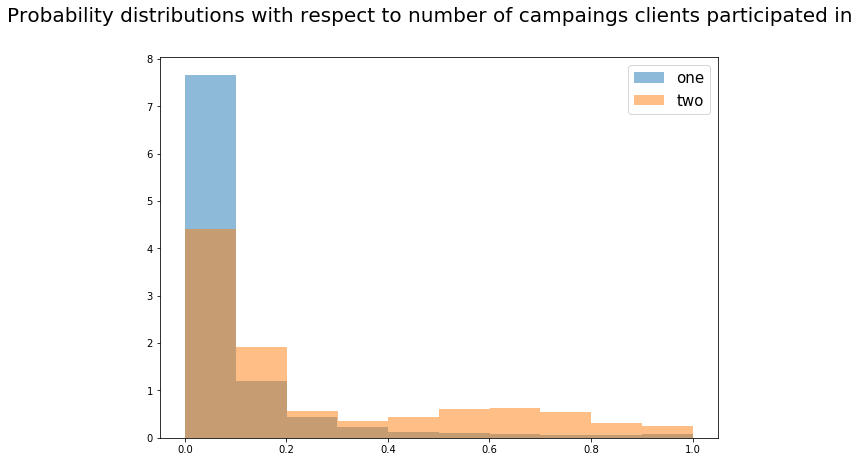

In [13]:
plt.figure(figsize=(10,7))
plt.hist(prob_once['once'],label='one',alpha=0.5,density=True)
plt.hist(prob_twice['twice'],label='two',alpha=0.5,density=True)
plt.legend(loc='best', prop={'size': 15})
plt.suptitle('Probability distributions with respect to number of campaings clients participated in', fontsize=20)
plt.xlabel('', fontsize=1)
plt.ylabel('', fontsize=1)
plt.show

### From above graphs we can clearly see that two distributions are different.

# Creating train/test sets

In [14]:
features=bank_ready.iloc[:, np.r_[0:14, 15]]
labels=bank_ready.iloc[:,np.r_[14]]

In [15]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, 
                                                                            test_size = 0.2, random_state = 100,stratify=labels)
test_features

,age,job,marital,education,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,euribor3m,houisng
30877,52,1,1,3,0,0,6,3,57,1,999,0,1,1.344,0
31058,36,4,1,2,1,0,6,4,438,1,999,0,1,1.334,1
31903,35,4,1,6,0,0,6,2,437,3,999,1,0,1.327,0
1344,30,0,0,3,0,1,6,2,177,1,999,0,1,4.855,1
8204,50,6,1,6,0,1,4,3,157,1,999,0,1,4.864,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32162,57,5,2,6,0,0,6,0,208,1,999,0,1,1.313,0
11334,26,1,2,2,0,1,4,2,60,4,999,0,1,4.961,0
2217,54,9,1,6,1,1,6,1,123,7,999,0,1,4.857,0
13805,30,6,1,6,0,1,3,2,148,20,999,0,1,4.963,1


### For further analysis we need to split our data into features and labels. Labels are values of the response variable - outcome of the marketing campaign. The rest of the variables are features. We also split data set into training and test data sets to perform predictions' evaluation while applying machine learning models. We use 80% of original data as training set and 20% is left for test set. We use startification by response variable to get equal proportions of each class in training and test sets. We do this as we deal with imbalanced classes problem: the number of people refused to place deposit is much higher.

# PCA Dimensionality Reduction

Text(0, 0.5, 'Cumulative Explained Variance')

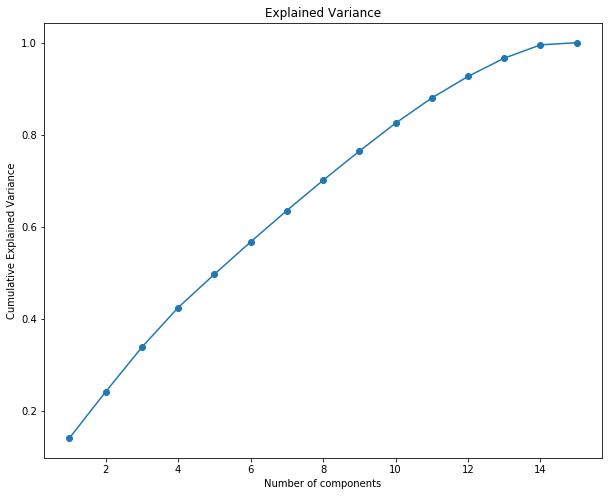

In [16]:
scaler=StandardScaler()
segm_std=scaler.fit_transform(features)
pca=PCA()
pca.fit(segm_std)
pca.explained_variance_ratio_
plt.figure(figsize=(10,8))
plt.plot(range(1,16),pca.explained_variance_ratio_.cumsum(),marker='o')
plt.title('Explained Variance')
plt.xlabel('Number of components')
plt.ylabel('Cumulative Explained Variance')

### We checked two groups of clients are different. Thus, to conduct further analysis we must use different approach. We will conduct clustering analysis to break down clients into segments. But before we do this we need to reduce our data dimesionality. Above graph shows number of components and corresponding variance explained. We choose 7 components which explain more about 70% of total variance. In this way we reduced data dimesionality by factor of 2.

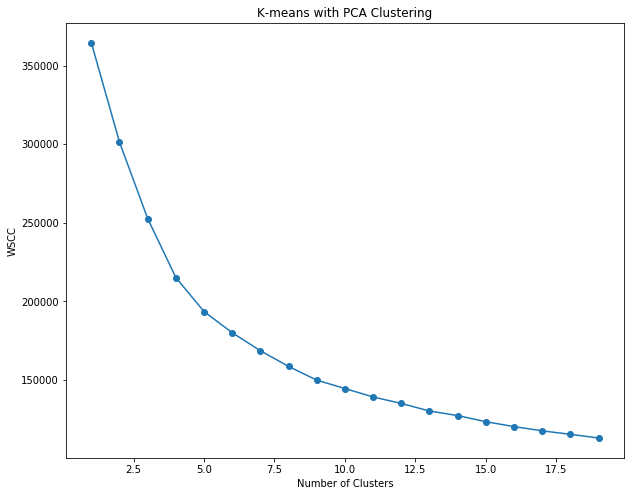

In [17]:
pca=PCA(n_components=7, random_state=100)
pca.fit(segm_std)
pca.transform(segm_std)
scores_pca=pca.transform(segm_std)
wcss=[]
for i in range(1,20):
    k_pca=KMeans(n_clusters=i,init='k-means++',random_state=100)
    k_pca.fit(scores_pca)
    wcss.append(k_pca.inertia_)
plt.figure(figsize=(10,8))
plt.plot(range(1,20),wcss,marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WSCC')
plt.title('K-means with PCA Clustering')
plt.show()

### We apply elbow method to identify appropriate number of clasters. We select such number of clusters that after this number the delcine speed of the curve stays the same. Using this rule we select 4 clusters.

In [18]:
k_pca=KMeans(n_clusters=4, init='k-means++',random_state=100)
k_pca.fit(scores_pca)
k_pca_df=pd.concat([features.reset_index(drop=True),pd.DataFrame(scores_pca)],axis=1)
k_pca_df.columns.values[-7:]=['component 1','component 2','component 3','component 4',
                              'component 5','component 6','component 7']
k_pca_df['segments']=k_pca.labels_
bank_graph['segments']=k_pca.labels_
k_pca_df

,age,job,marital,education,loan,contact,month,day_of_week,duration,campaign,...,euribor3m,houisng,component 1,component 2,component 3,component 4,component 5,component 6,component 7,segments
0,56,3,1,0,0,1,6,1,261,1,...,4.857,0,-1.403001,2.072406,-0.757625,0.943943,-0.094757,-0.455048,0.575195,2
1,57,7,1,3,0,1,6,1,149,1,...,4.857,0,-1.233050,1.464029,-0.315564,0.438523,-0.813605,-1.449811,-0.360560,2
2,37,7,1,3,0,1,6,1,226,1,...,4.857,1,-1.004742,0.313826,0.128513,0.800052,-0.372025,-0.451564,-1.148540,2
3,40,0,1,1,0,1,6,1,151,1,...,4.857,0,-1.354837,1.145592,-0.380527,1.533558,-0.184343,0.100907,0.991726,2
4,56,7,1,3,1,1,6,1,307,1,...,4.857,0,-1.185552,1.359375,-0.247557,0.357767,-0.379389,-0.053032,-1.740453,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38240,73,5,1,5,0,0,7,0,334,1,...,1.028,1,0.949409,1.507422,-1.162665,-1.139928,-0.311892,-0.427130,-0.934860,1
38241,46,1,1,5,0,0,7,0,383,1,...,1.028,0,0.854666,0.383037,-0.579123,0.297272,-0.062928,-0.409767,0.805827,1
38242,56,5,1,6,0,0,7,0,189,2,...,1.028,1,0.968674,0.418242,-0.636683,-0.712114,-0.844392,-0.263586,-0.866878,1
38243,44,9,1,5,0,0,7,0,442,1,...,1.028,0,0.959051,0.036271,-0.241489,-0.032774,-0.392663,-1.732021,-0.298709,1


In [20]:
k_pca_df=pd.concat([features.reset_index(drop=True),pd.DataFrame(scores_pca)],axis=1)
k_pca_df.columns.values[-7:]=['component 1','component 2','component 3','component 4',
                              'component 5','component 6','component 7']
k_pca_df['segments']=k_pca.labels_
bank_graph['segments']=k_pca.labels_
k_pca_df

,age,job,marital,education,loan,contact,month,day_of_week,duration,campaign,...,euribor3m,houisng,component 1,component 2,component 3,component 4,component 5,component 6,component 7,segments
0,56,3,1,0,0,1,6,1,261,1,...,4.857,0,-1.403001,2.072406,-0.757625,0.943943,-0.094757,-0.455048,0.575195,2
1,57,7,1,3,0,1,6,1,149,1,...,4.857,0,-1.233050,1.464029,-0.315564,0.438523,-0.813605,-1.449811,-0.360560,2
2,37,7,1,3,0,1,6,1,226,1,...,4.857,1,-1.004742,0.313826,0.128513,0.800052,-0.372025,-0.451564,-1.148540,2
3,40,0,1,1,0,1,6,1,151,1,...,4.857,0,-1.354837,1.145592,-0.380527,1.533558,-0.184343,0.100907,0.991726,2
4,56,7,1,3,1,1,6,1,307,1,...,4.857,0,-1.185552,1.359375,-0.247557,0.357767,-0.379389,-0.053032,-1.740453,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38240,73,5,1,5,0,0,7,0,334,1,...,1.028,1,0.949409,1.507422,-1.162665,-1.139928,-0.311892,-0.427130,-0.934860,1
38241,46,1,1,5,0,0,7,0,383,1,...,1.028,0,0.854666,0.383037,-0.579123,0.297272,-0.062928,-0.409767,0.805827,1
38242,56,5,1,6,0,0,7,0,189,2,...,1.028,1,0.968674,0.418242,-0.636683,-0.712114,-0.844392,-0.263586,-0.866878,1
38243,44,9,1,5,0,0,7,0,442,1,...,1.028,0,0.959051,0.036271,-0.241489,-0.032774,-0.392663,-1.732021,-0.298709,1


### Finally, we apply K-Means to components. In each step of PCA and K-Means estimation we control for randomness to get consistent results. We append obtained components and cluster to the rest data set. Now we are ready to perform further analysis.

# Segments Specific Analysis

In [21]:
bank_graph

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,euribor3m,y,segments
0,56,housemaid,married,basic.4y,no,no,telephone,may,mon,261,1,999,0,nonexistent,4.857,no,2
1,57,services,married,high.school,no,no,telephone,may,mon,149,1,999,0,nonexistent,4.857,no,2
2,37,services,married,high.school,yes,no,telephone,may,mon,226,1,999,0,nonexistent,4.857,no,2
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,151,1,999,0,nonexistent,4.857,no,2
4,56,services,married,high.school,no,yes,telephone,may,mon,307,1,999,0,nonexistent,4.857,no,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,1.028,yes,1
41184,46,blue-collar,married,professional.course,no,no,cellular,nov,fri,383,1,999,0,nonexistent,1.028,no,1
41185,56,retired,married,university.degree,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,1.028,no,1
41186,44,technician,married,professional.course,no,no,cellular,nov,fri,442,1,999,0,nonexistent,1.028,yes,1


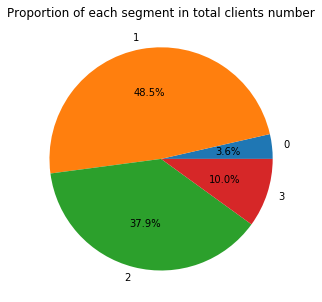

In [22]:
plt.figure(figsize=(5,5))
pie_ch=bank_graph.groupby(bank_graph['segments']).count()
plt.axis('equal')
plt.pie(pie_ch['age'], labels=pie_ch.index,autopct='%1.1f%%')
plt.title('Proportion of each segment in total clients number')
plt.show()

### We see from pie chart that segments 1 and 2 are the most represented segments. However we are interested in assesing efficiency of this marketing campaign. We must look at portion of positive outcomes in each segment.

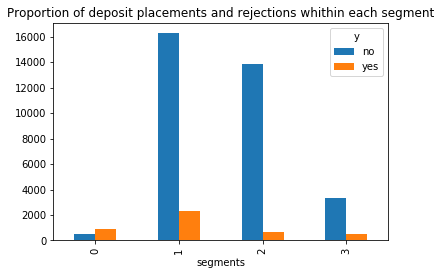

In [23]:
bch=bank_graph[['y','segments']]
table = pd.pivot_table(bch, index=['segments'],columns=['y'], aggfunc=len)
table.plot.bar(title='Proportion of deposit placements and rejections whithin each segment')

### As we can see from the bar chart the most efficient segment is segment 0. Proportion of positive outcomes is even higher then proportion of negative outcomes. Other segments are less efficient. Let's calculate exact conversion rates for each segment.

In [24]:
conv=bch
conversion_rate_0=conv.loc[(conv['y']=='yes')&(conv['segments']==0)].count()/conv.loc[conv['segments']==0].count()*100
conversion_rate_1=conv.loc[(conv['y']=='yes')&(conv['segments']==1)].count()/conv.loc[conv['segments']==1].count()*100
conversion_rate_2=conv.loc[(conv['y']=='yes')&(conv['segments']==2)].count()/conv.loc[conv['segments']==2].count()*100
conversion_rate_3=conv.loc[(conv['y']=='yes')&(conv['segments']==3)].count()/conv.loc[conv['segments']==3].count()*100
print('Positive conversion rate within each segment')
print('segment 0') 
print(conversion_rate_0['y'])
print('segment 1') 
print(conversion_rate_1['y'])
print('segment 2')
print(conversion_rate_2['y'])
print('segment 3')
print(conversion_rate_3['y'])

Positive conversion rate within each segment
segment 0
63.32357247437774
segment 1
12.308687217072645
segment 2
4.397573752412462
segment 3
12.346002621231978


### Now we know that conversion rate for segment 0 is 63.32%. As it turned out the least efficient segment is segment 2 with onversion rate only 4.40%. Other two segments show approximately the same conversion rate regarding each other.

In [25]:
conversion_rate_0_yes=conv.loc[(conv['y']=='yes')&(conv['segments']==0)].count()/conv.loc[conv['y']=='yes'].count()*100
conversion_rate_1_yes=conv.loc[(conv['y']=='yes')&(conv['segments']==1)].count()/conv.loc[conv['y']=='yes'].count()*100
conversion_rate_2_yes=conv.loc[(conv['y']=='yes')&(conv['segments']==2)].count()/conv.loc[conv['y']=='yes'].count()*100
conversion_rate_3_yes=conv.loc[(conv['y']=='yes')&(conv['segments']==3)].count()/conv.loc[conv['y']=='yes'].count()*100
print('Positive conversion rate of each segment with respect to total number of deposit placements')
print('segment 0') 
print(conversion_rate_0_yes['y'])
print('segment 1') 
print(conversion_rate_1_yes['y'])
print('segment 2')
print(conversion_rate_2_yes['y'])
print('segment 3')
print(conversion_rate_3_yes['y'])

Positive conversion rate of each segment with respect to total number of deposit placements
segment 0
20.314701737905118
segment 1
53.64020666979803
segment 2
14.983560356975106
segment 3
11.061531235321748


### But we may want to know not only conversion rate within each segment. We may be also interested in performance of each segment with respect to total number of positive and negative outcomes. From rates above we can conclude that segment 2 carries more then a half of all positive outcomes. It might be interesting to bank's managment regardless this segment's relatively low conversion rate (12.31%). They might still want to invest time and effort to get those additional deposits. The possible reason could be increase in market share. Also they could target some indicators in absolute terms.

In [26]:
conversion_rate_0_no=conv.loc[(conv['y']=='no')&(conv['segments']==0)].count()/conv.loc[conv['y']=='no'].count()*100
conversion_rate_1_no=conv.loc[(conv['y']=='no')&(conv['segments']==1)].count()/conv.loc[conv['y']=='no'].count()*100
conversion_rate_2_no=conv.loc[(conv['y']=='no')&(conv['segments']==2)].count()/conv.loc[conv['y']=='no'].count()*100
conversion_rate_3_no=conv.loc[(conv['y']=='no')&(conv['segments']==3)].count()/conv.loc[conv['y']=='no'].count()*100
print('Negative conversion rate for each segment with respet to total number of rejections')
print('segment 0') 
print(conversion_rate_0_no['y'])
print('segment 1') 
print(conversion_rate_1_no['y'])
print('segment 2')
print(conversion_rate_2_no['y'])
print('segment 3')
print(conversion_rate_3_no['y'])

Negative conversion rate for each segment with respet to total number of rejections
segment 0
1.4740930355724249
segment 1
47.877129490687615
segment 2
40.80972136405096
segment 3
9.839056109688999


### On the other hand, if we look at rejection statistics, segment 1 is still in the lead. So it's up to bank's management to decide if the cost of working on this segment is worth gain in revenue or market share. But from this statistics we can conclude that segment 2 is the worst segment with 4.40% conversion rate and 40.81% of total rejections number.

# Segment 0 (most efficient) and Segment 2 (least efficient in both terms) Analysis

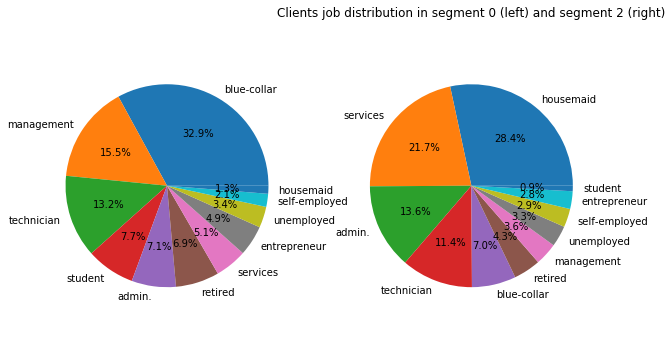

In [27]:
plt.figure(figsize=(10,6))
bank_seg0=bank_graph.loc[bank_graph['segments']==0]
bank_seg0_yes=bank_seg0.loc[bank_graph['y']=='yes']
plt.subplot(1,2,1) 
plt.axis('equal')
plt.pie(bank_seg0_yes['job'].value_counts(),labels=bank_seg0_yes['job'].unique(),autopct='%1.1f%%')
bank_seg2=bank_graph.loc[bank_graph['segments']==2]
bank_seg2_no=bank_seg2.loc[bank_graph['y']=='no']
plt.subplot(1,2,2)
plt.axis('equal')
plt.pie(bank_seg2_no['job'].value_counts(),labels=bank_seg2_no['job'].unique(),autopct='%1.1f%%')
plt.title('Clients job distribution in segment 0 (left) and segment 2 (right)')
plt.show()


### Here and further in our segments analysis we will study clients in segment 0, who placed deposit, and clients in segment 2, who rejected to place deposit. We start with analysis of the most efficient segment. We study breakdown by job for clients in segment 0, who placed deposit. Surprisingly, the largest share is belong to blue collar workers. Also substantial part is occupied by management and technicians. Now we study rejections in least efficient segment 2. Housemaids, service employees and administrative staff are prevail in this segment. Clients' job distribution is quite different for these segments.

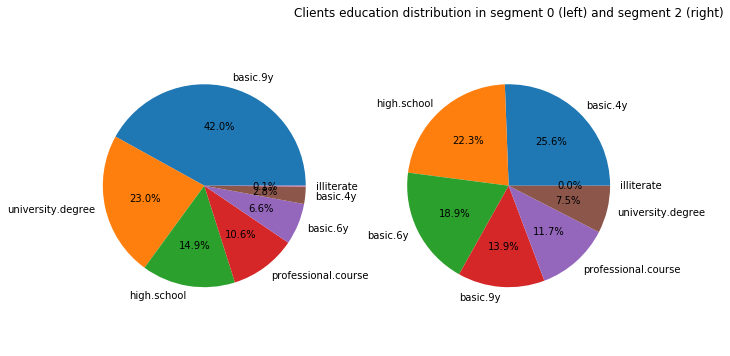

In [28]:
plt.figure(figsize=(10,6))
bank_seg0=bank_graph.loc[bank_graph['segments']==0]
bank_seg0_yes=bank_seg0.loc[bank_graph['y']=='yes']
plt.subplot(1,2,1) 
plt.axis('equal')
plt.pie(bank_seg0_yes['education'].value_counts(),labels=bank_seg0_yes['education'].unique(),autopct='%1.1f%%')
bank_seg2=bank_graph.loc[bank_graph['segments']==2]
bank_seg2_no=bank_seg2.loc[bank_graph['y']=='no']
plt.subplot(1,2,2)
plt.axis('equal')
plt.pie(bank_seg2_no['education'].value_counts(),labels=bank_seg2_no['education'].unique(),autopct='%1.1f%%')
plt.title('Clients education distribution in segment 0 (left) and segment 2 (right)')
plt.show()

### Breakdown by education starts to make previous result consistent in some way. Most clients of this segment who decided to place the deposit have 9 years of basic education. Probably, that is what we expect from people: to work as blue-collar with such level of education. Another huge part is people with university degree, who are most likely managers. In least efficient segment 2 more people have lower level of education compared to most efficient.¶

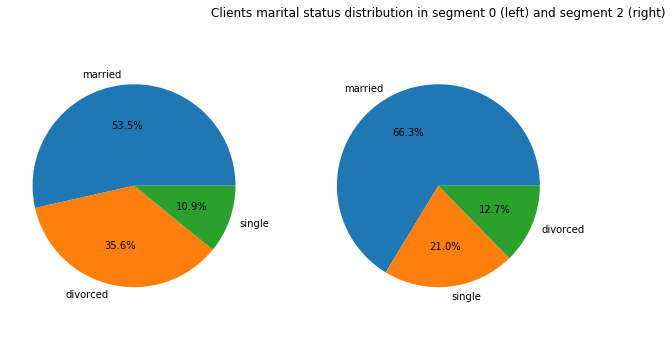

In [29]:
plt.figure(figsize=(10,6))
bank_seg0=bank_graph.loc[bank_graph['segments']==0]
bank_seg0_yes=bank_seg0.loc[bank_graph['y']=='yes']
plt.subplot(1,2,1) 
plt.axis('equal')
plt.pie(bank_seg0_yes['marital'].value_counts(),labels=bank_seg0_yes['marital'].unique(),autopct='%1.1f%%')
bank_seg2=bank_graph.loc[bank_graph['segments']==2]
bank_seg2_no=bank_seg2.loc[bank_graph['y']=='no']
plt.subplot(1,2,2)
plt.axis('equal')
plt.pie(bank_seg2_no['marital'].value_counts(),labels=bank_seg2_no['marital'].unique(),autopct='%1.1f%%')
plt.title('Clients marital status distribution in segment 0 (left) and segment 2 (right)')
plt.show()

### In segment 0 most clients are married or divorced. Little space for middle ground (to be single) is this segment's positive outcomes. In segment 2 portion of married people is higher. There is much less divorced and much more single people is this segment

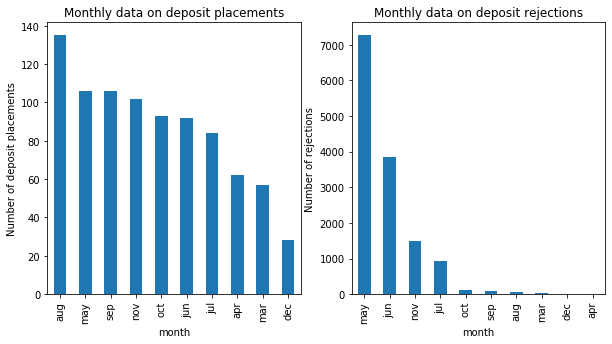

In [30]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
bank_seg0_yes['month'].value_counts().plot.bar()
plt.xlabel('month')
plt.ylabel('Number of deposit placements')
plt.title('Monthly data on deposit placements')
plt.subplot(1,2,2)
bank_seg2_no['month'].value_counts().plot.bar()
plt.xlabel('month')
plt.ylabel('Number of rejections')
plt.title('Monthly data on deposit rejections')
plt.show()

### The least successful month to contact is december, the most - august. April and March are little bit lower than the rest months. May, September, November, October and July are approximately at the same high level. Bank received most part of rejections from segment 2 contacting clients in May.

<Figure size 720x360 with 0 Axes>

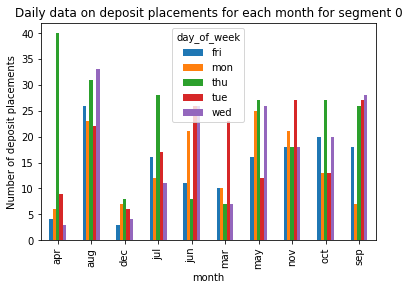

In [31]:
bank_seg0_yes_md=bank_seg0_yes[['month','day_of_week']]
table_md_yes = pd.pivot_table(bank_seg0_yes_md, index=['month'],columns=['day_of_week'], aggfunc=len)
bank_seg2_no_md=bank_seg2_no[['month','day_of_week']]
table_md_no = pd.pivot_table(bank_seg2_no_md, index=['month'],columns=['day_of_week'], aggfunc=len)
plt.figure(figsize=(10,5))
table_md_yes.plot.bar()
plt.xlabel('month')
plt.ylabel('Number of deposit placements')
plt.title('Daily data on deposit placements for each month for segment 0')
plt.show()

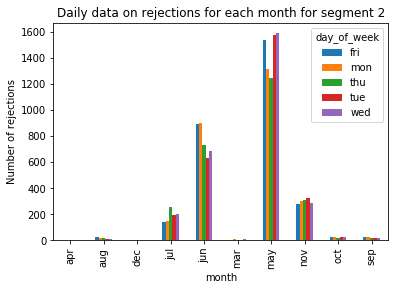

In [32]:
table_md_no.plot.bar()
plt.xlabel('month')
plt.ylabel('Number of rejections')
plt.title('Daily data on rejections for each month for segment 2')
plt.show()

### For segment 0 wednesday and Thursday are the best days to contact people in August. We can also see that Tuesday demostrates outstanding performance in May. December is still the worst month in this breakdown. We can also notice Thursday in April as the best day overall. In week day breakdown we also see May as the worst month for segment 2.

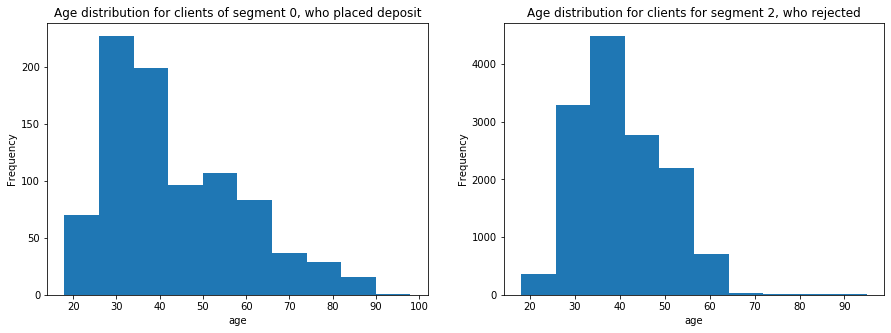

In [33]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
bank_seg0_yes['age'].plot.hist()
plt.xlabel('age')
plt.title('Age distribution for clients of segment 0, who placed deposit')
plt.subplot(1,2,2)
bank_seg2_no['age'].plot.hist()
plt.xlabel('age')
plt.title('Age distribution for clients for segment 2, who rejected')
plt.show()

### We can make a conclusion that the majority of people are at their's 30s and 40s for segment 0. Age distribution for segment 2 is more skewed to people older than 35.

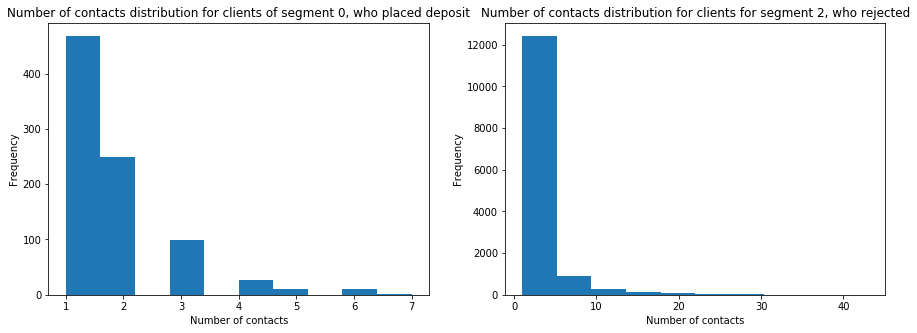

In [34]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
bank_seg0_yes['campaign'].plot.hist()
plt.xlabel('Number of contacts')
plt.title('Number of contacts distribution for clients of segment 0, who placed deposit')
plt.subplot(1,2,2)
bank_seg2_no['campaign'].plot.hist()
plt.xlabel('Number of contacts')
plt.title('Number of contacts distribution for clients for segment 2, who rejected')
plt.show()

### Most clients in segment 0 were contacted no more than twice during this campaign. People in segment 2 were contacted no more than 5 times

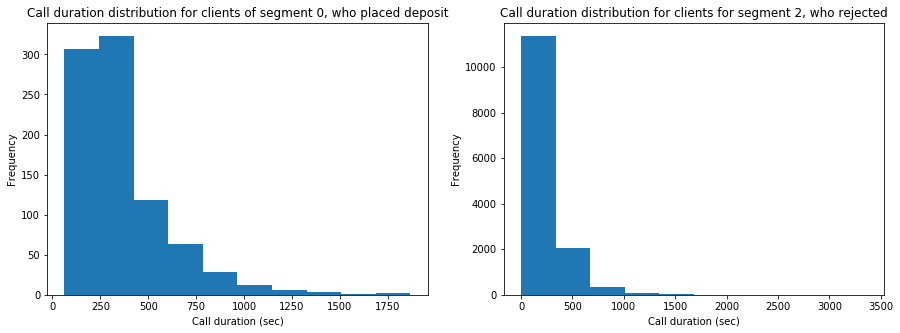

In [35]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
bank_seg0_yes['duration'].plot.hist()
plt.xlabel('Call duration (sec)')
plt.title('Call duration distribution for clients of segment 0, who placed deposit')
plt.subplot(1,2,2)
bank_seg2_no['duration'].plot.hist()
plt.xlabel('Call duration (sec)')
plt.title('Call duration distribution for clients for segment 2, who rejected')
plt.show()

### Call duration was about 360 seconds or 6 minutes for clients in segment 0. Approximate duration is about 5 minutes for clients in segment 2.

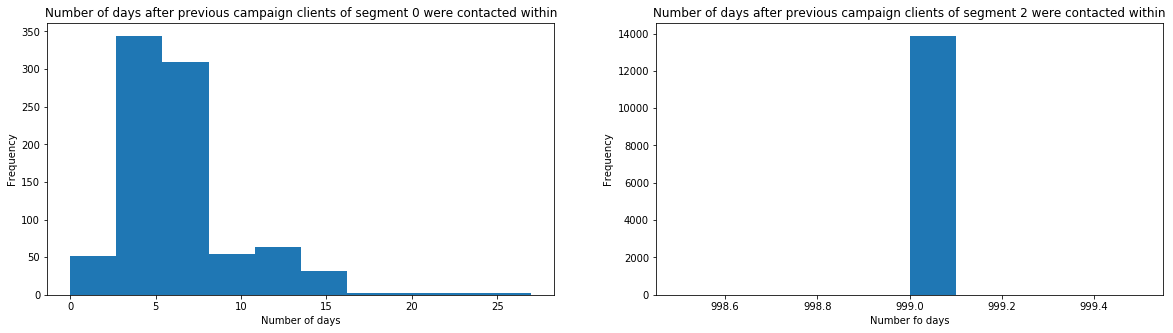

In [36]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
bank_seg0_yes['pdays'].plot.hist()
plt.xlabel('Number of days')
plt.title('Number of days after previous campaign clients of segment 0 were contacted within')
plt.subplot(1,2,2)
bank_seg2_no['pdays'].plot.hist()
plt.xlabel('Number fo days')
plt.title('Number of days after previous campaign clients of segment 2 were contacted within')
plt.show()

### Most clients in segment 0 were contacted within 8 days from previous campaign (if they participated). Clients from segment 2 did not participate in previous campaign. 

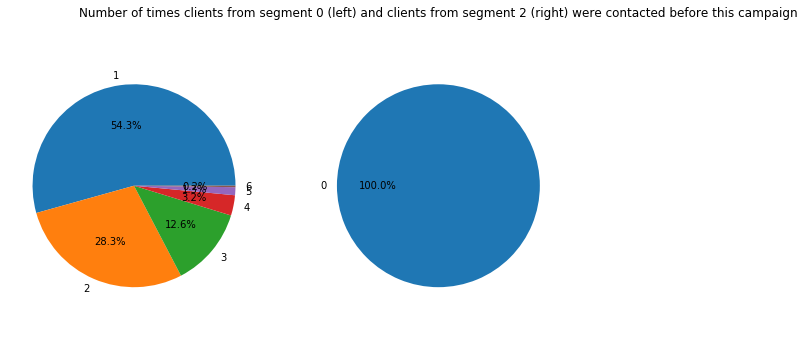

In [37]:
plt.figure(figsize=(10,6))
bank_seg0=bank_graph.loc[bank_graph['segments']==0]
bank_seg0_yes=bank_seg0.loc[bank_graph['y']=='yes']
plt.subplot(1,2,1) 
plt.axis('equal')
plt.pie(bank_seg0_yes['previous'].value_counts(),labels=bank_seg0_yes['previous'].unique(),autopct='%1.1f%%')
bank_seg2=bank_graph.loc[bank_graph['segments']==2]
bank_seg2_no=bank_seg2.loc[bank_graph['y']=='no']
plt.subplot(1,2,2)
plt.axis('equal')
plt.pie(bank_seg2_no['previous'].value_counts(),labels=bank_seg2_no['previous'].unique(),autopct='%1.1f%%')
plt.title('Number of times clients from segment 0 (left) and clients from segment 2 (right) were contacted before this campaign')
plt.show()

### Most  clients in segment 0 were contacted no more than 2 times before current campaign. Bank did not contact people in segment 2 before this campaign. May be these are completely new clients

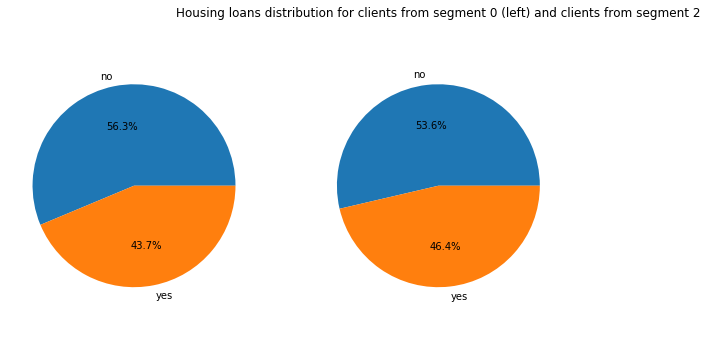

In [38]:
plt.figure(figsize=(10,6))
bank_seg0=bank_graph.loc[bank_graph['segments']==0]
bank_seg0_yes=bank_seg0.loc[bank_graph['y']=='yes']
plt.subplot(1,2,1) 
plt.axis('equal')
plt.pie(bank_seg0_yes['housing'].value_counts(),labels=bank_seg0_yes['housing'].unique(),autopct='%1.1f%%')
bank_seg2=bank_graph.loc[bank_graph['segments']==2]
bank_seg2_no=bank_seg2.loc[bank_graph['y']=='no']
plt.subplot(1,2,2)
plt.axis('equal')
plt.pie(bank_seg2_no['housing'].value_counts(),labels=bank_seg2_no['housing'].unique(),autopct='%1.1f%%')
plt.title('Housing loans distribution for clients from segment 0 (left) and clients from segment 2')
plt.show()

### Housing loan distribuiton among clients from different segments is more or less even.

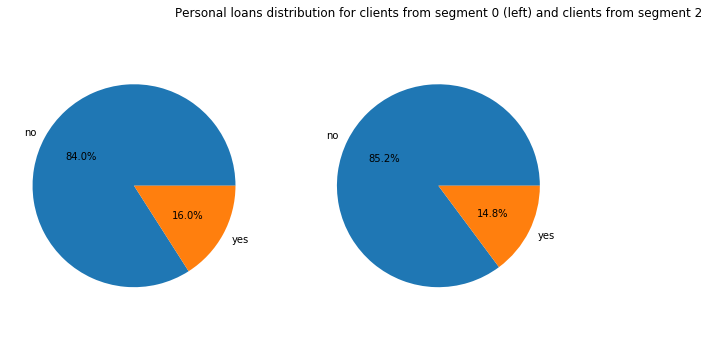

In [39]:
plt.figure(figsize=(10,6))
bank_seg0=bank_graph.loc[bank_graph['segments']==0]
bank_seg0_yes=bank_seg0.loc[bank_graph['y']=='yes']
plt.subplot(1,2,1) 
plt.axis('equal')
plt.pie(bank_seg0_yes['loan'].value_counts(),labels=bank_seg0_yes['loan'].unique(),autopct='%1.1f%%')
bank_seg2=bank_graph.loc[bank_graph['segments']==2]
bank_seg2_no=bank_seg2.loc[bank_graph['y']=='no']
plt.subplot(1,2,2)
plt.axis('equal')
plt.pie(bank_seg2_no['loan'].value_counts(),labels=bank_seg2_no['loan'].unique(),autopct='%1.1f%%')
plt.title('Personal loans distribution for clients from segment 0 (left) and clients from segment 2')
plt.show()

### Personal loan distribuiton among clients from different segments is more or less even.

# Segment 1 Analysis (most positive outcomes in absolute value)

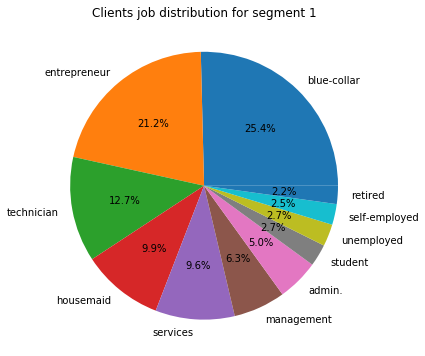

In [40]:
bank_seg1=bank_graph.loc[bank_graph['segments']==1]
bank_seg1_yes=bank_seg2.loc[bank_graph['y']=='yes']
plt.figure(figsize=(6,6))
plt.axis('equal')
plt.pie(bank_seg1_yes['job'].value_counts(),labels=bank_seg1_yes['job'].unique(),autopct='%1.1f%%')
plt.title('Clients job distribution for segment 1')
plt.show()

### Here and further we will study clients from segment 1, who placed deposit. Segment 1 contains most part of people who agreed to place deposit. Blue collars, enterpreneurs and technicians are best represented job ocupatons in this segment.

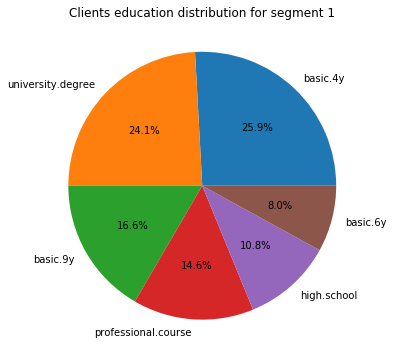

In [41]:
plt.figure(figsize=(6,6))
plt.axis('equal')
plt.pie(bank_seg1_yes['education'].value_counts(),labels=bank_seg1_yes['education'].unique(),autopct='%1.1f%%')
plt.title('Clients education distribution for segment 1')
plt.show()

### Those people have mostly university degree, 4 and 9 years of basic education

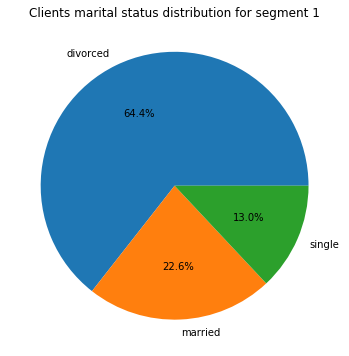

In [42]:
plt.figure(figsize=(6,6))
plt.axis('equal')
plt.pie(bank_seg1_yes['marital'].value_counts(),labels=bank_seg1_yes['marital'].unique(),autopct='%1.1f%%')
plt.title('Clients marital status distribution for segment 1')
plt.show()

### Unlike previously studied segments, this segment contains large portion of divorced people

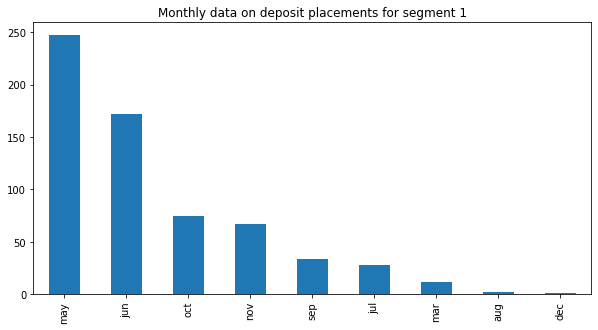

In [43]:
plt.figure(figsize=(10,5))
bank_seg1_yes['month'].value_counts().plot.bar(title='Monthly data on deposit placements for segment 1')
plt.show()

### May shows most positive outcomes. But May also demonstrated most rejections for segment 2. Probably we should pay more attention to June, October and November.

<Figure size 720x360 with 0 Axes>

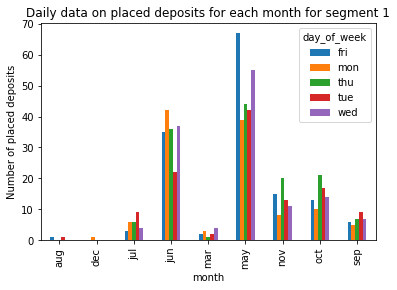

In [44]:
bank_seg1_yes_md=bank_seg1_yes[['month','day_of_week']]
table_md = pd.pivot_table(bank_seg1_yes_md, index=['month'],columns=['day_of_week'], aggfunc=len)
plt.figure(figsize=(10,5))
table_md.plot.bar()
plt.xlabel('month')
plt.ylabel('Number of placed deposits')
plt.title('Daily data on placed deposits for each month for segment 1')
plt.show()

### For June all week days except Tuesday demonstrate relatively even performance. May shows higher performance, especially on Fridays.

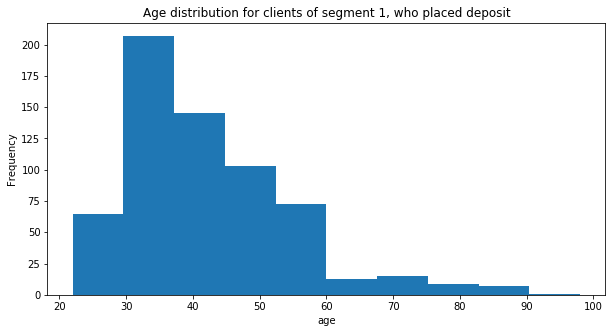

In [45]:
plt.figure(figsize=(10,5))
bank_seg1_yes['age'].plot.hist()
plt.xlabel('age')
plt.title('Age distribution for clients of segment 1, who placed deposit')
plt.show()

### Age distribution is more similar to segement 0

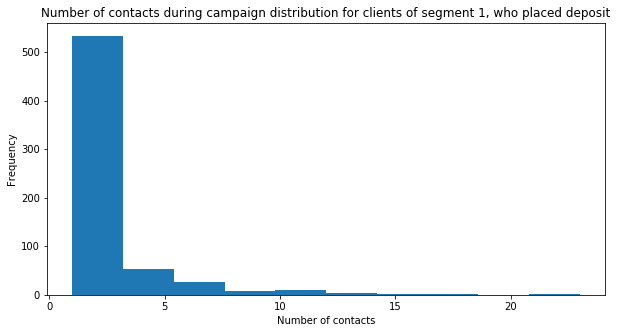

In [46]:
plt.figure(figsize=(10,5))
bank_seg1_yes['campaign'].plot.hist()
plt.xlabel('Number of contacts')
plt.title('Number of contacts during campaign distribution for clients of segment 1, who placed deposit')
plt.show()

### Most clients were contacted no more than 3 times. Which is close to 2 times in segment 0.

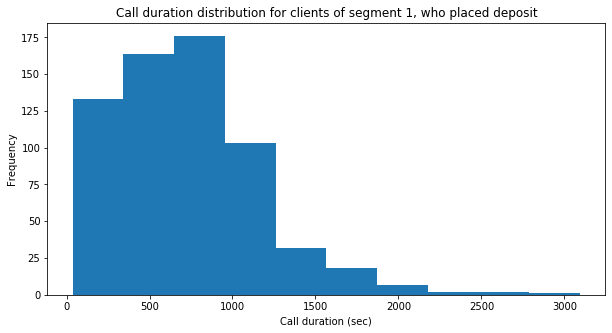

In [47]:
plt.figure(figsize=(10,5))
bank_seg1_yes['duration'].plot.hist()
plt.xlabel('Call duration (sec)')
plt.title('Call duration distribution for clients of segment 1, who placed deposit')
plt.show()

### Distribution of call duration is different from previous segments. Most calls last more than 8 minutes. Also most clients did not participate in previous campaign. They were not contacted before this campaign as well.

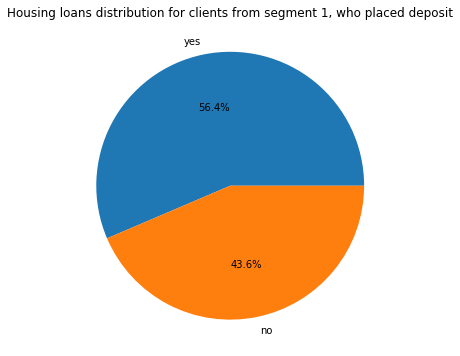

In [48]:
plt.figure(figsize=(6,6))
plt.axis('equal')
plt.pie(bank_seg1_yes['housing'].value_counts(),labels=bank_seg1_yes['housing'].unique(),autopct='%1.1f%%')
plt.title('Housing loans distribution for clients from segment 1, who placed deposit')
plt.show()

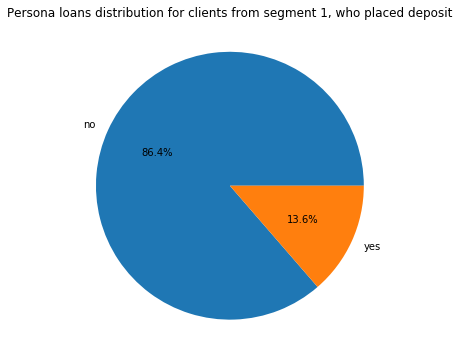

In [49]:
plt.figure(figsize=(6,6))
plt.axis('equal')
plt.pie(bank_seg1_yes['loan'].value_counts(),labels=bank_seg1_yes['loan'].unique(),autopct='%1.1f%%')
plt.title('Persona loans distribution for clients from segment 1, who placed deposit')
plt.show()

### Distribution for hosing and personal loans is the same as for previously analized segments

# RANDOM FOREST
### Please, ignore warnings in output and scroll down to see results

In [51]:
rf = BalancedRandomForestClassifier()
grid_rf = {'max_depth': np.arange(1, 20, 1), 'max_features':['auto', 'sqrt']}
rf_opt = GridSearchCV(rf, grid_rf, n_jobs=-1, cv=5)
rf_opt.fit(train_features, train_labels)
rf_opt.best_params_

{'max_depth': 14, 'max_features': 'auto'}

In [52]:
rf1 = BalancedRandomForestClassifier(n_estimators=1000, max_depth = 14, max_features='auto', n_jobs=-1, random_state=100)
rf2=rf1.fit(train_features,train_labels)
cv_scores = cross_val_score(rf2, test_features, test_labels, cv=5)
print('Cross-validation scores')
print(cv_scores)
print('Mean score')
print(mean(cv_scores))


Cross-validation scores
[0.83529412 0.85098039 0.84052288 0.83202614 0.86134729]
Mean score
0.8440341630438966


In [53]:
random_forest = BalancedRandomForestClassifier(n_estimators=1000, max_depth=14, max_features='auto',n_jobs=-1)
random_forest.fit(train_features,train_labels)
random_forest_predict = random_forest.predict(test_features)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=100)
n_scores = cross_val_score(random_forest, train_features, train_labels, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
print("=== Confusion Matrix ===")
print(confusion_matrix(test_labels, random_forest_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(test_labels, random_forest_predict))
print('\n')
print("=== All AUC Scores ===")
print(n_scores)
print('\n')

Accuracy: 0.850 (0.007)
=== Confusion Matrix ===
[[5668 1129]
 [  49  803]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.99      0.83      0.91      6797
           1       0.42      0.94      0.58       852

    accuracy                           0.85      7649
   macro avg       0.70      0.89      0.74      7649
weighted avg       0.93      0.85      0.87      7649



=== All AUC Scores ===
[0.84673203 0.85490196 0.8496732  0.85392157 0.84248366 0.85392157
 0.85158549 0.85779667 0.84668192 0.84602811 0.85359477 0.85196078
 0.84411765 0.8372549  0.84803922 0.84901961 0.84798954 0.87185355
 0.83883622 0.85681595 0.85326797 0.85294118 0.84738562 0.84150327
 0.84509804 0.86045752 0.84210526 0.85681595 0.85387381 0.84798954]




### We choose max_depth of 14 and max_feature auto selection as the resault of cross-validation. Number of trees is correlated positively with model's performance: more the better. Thus, we use 1000 trees. Average cross-validation score is 84.40%. 
### From performance metrics above we see that balanced random forest's test accuracy is 85%. For this classification problem we are more interested in correcct positive class prediction. In confusion matrix this is number in bottom right corner. So from 852 clinets who placed deposit we correctly predicted 800 of them.

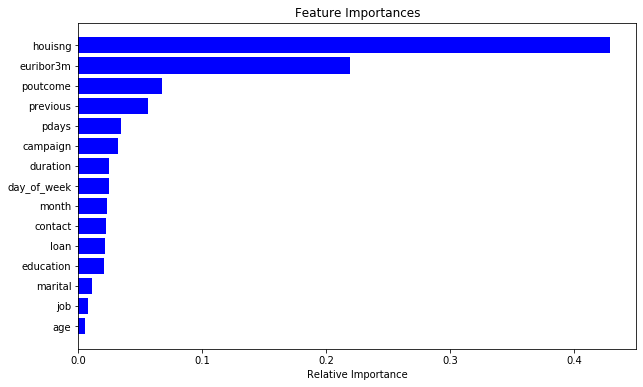

In [54]:
importances = random_forest.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10,6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features)
plt.xlabel('Relative Importance')
plt.show()

### The most important features selected by random forest are housing, daily interest rate for 3 month deposits, outcome of the previous campaign and number of contacts before current campaign

[[5668 1129]
 [  49  803]]


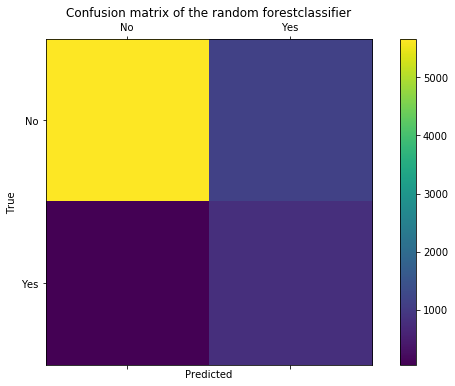

In [55]:
labels = ['No', 'Yes']
cm = confusion_matrix(test_labels, random_forest_predict)
print(cm)
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the random forestclassifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

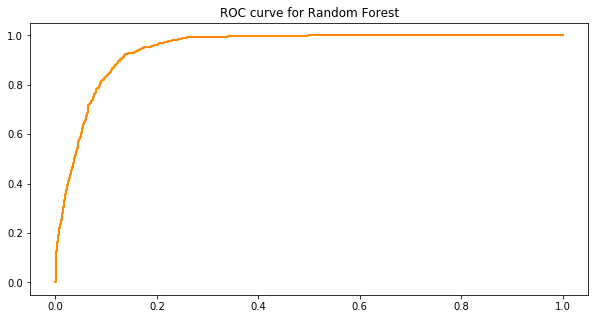

In [56]:
y_score_rf = random_forest.predict_proba(test_features)[:,1]

fpr, tpr, threshold = roc_curve(test_labels,y_score_rf)
auc_score = auc(fpr, tpr)
plt.figure(figsize=(10,5))
plt.plot(fpr, tpr, color='darkorange', lw=2,
             label='micro-AUC = {0:0.2f}'
             ''.format(auc_score))
plt.title('ROC curve for Random Forest')
plt.show()

# XGBOOST
### Please, ignore warnings in output

In [57]:
xgb = XGBClassifier()
grid_xgb = {'n_estimators':np.arange(55,65,1),'max_depth': np.arange(1, 5, 1)}
xgb_opt = GridSearchCV(xgb, grid_xgb, cv=5,n_jobs = -1)
xgb_opt.fit(train_features, train_labels)
xgb_opt.best_params_

{'max_depth': 3, 'n_estimators': 58}

In [58]:
xgb1 = XGBClassifier(n_estimators=58, max_depth = 3, learning_rate=0.001,random_state=100, n_jobs=-1, scale_pos_weight=7)
xgb2=xgb1.fit(train_features,train_labels)
cv_scores_xgb = cross_val_score(xgb2, test_features, test_labels, cv=5)
print('Cross-validation scores')
print(cv_scores_xgb)
print('Mean score')
print(mean(cv_scores_xgb))

Cross-validation scores
[0.85555556 0.87843137 0.81633987 0.85228758 0.86527142]
Mean score
0.8535771596626442


In [59]:
model_xgb = XGBClassifier(n_estimators=58,max_depth=3,learning_rate=0.001,random_state=100, n_jobs=-1, scale_pos_weight=7)
model_xgb.fit(train_features,train_labels)
model_xgb_predict = model_xgb.predict(test_features)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=100)
n_scores = cross_val_score(model_xgb, train_features, train_labels, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
print("=== Confusion Matrix ===")
print(confusion_matrix(test_labels, model_xgb_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(test_labels, model_xgb_predict))
print('\n')
print("=== All AUC Scores ===")
print(n_scores)
print('\n')

Accuracy: 0.868 (0.009)
=== Confusion Matrix ===
[[5951  846]
 [ 160  692]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.97      0.88      0.92      6797
           1       0.45      0.81      0.58       852

    accuracy                           0.87      7649
   macro avg       0.71      0.84      0.75      7649
weighted avg       0.92      0.87      0.88      7649



=== All AUC Scores ===
[0.85196078 0.87089394 0.86370322 0.87399902 0.86435692 0.8753268
 0.85177317 0.85324399 0.88118974 0.87089394 0.87075163 0.87089394
 0.87334532 0.87939206 0.8668083 ]




### Unlike random forest, XGBoost model could suffer from overfitting if number of estimators is too large. So we must cross validate over this parameter too. Learning parameter is set to 0.001. We also use weight parameter to account for imbalassed classes. From cross-validation we get number of estimators of 58 and max_deph of 3. Average cross-validation score is 85.36%.
### Test accuracy of the model is 86.8%. It is higher than for random forest. However, this model makes worse prediction for positive class. Out of 852 people who placed deposit it predicted only 692 of them.

Text(0.5, 0, 'Relative Importance')

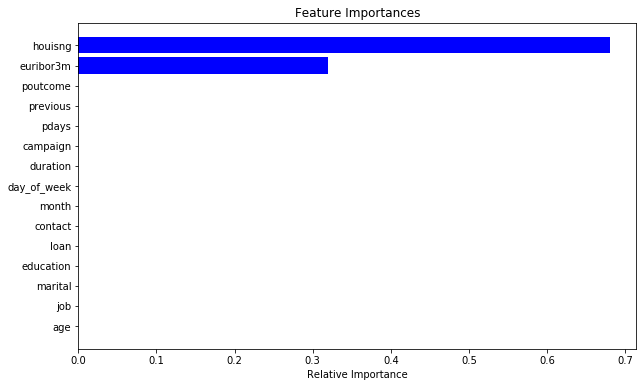

In [60]:
importances = model_xgb.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10,6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features)
plt.xlabel('Relative Importance')

### Like Random Forest, XGBoost considers housing loan and 3 motnh deposit rate as important variables, but ignores the rest variables.

[[5951  846]
 [ 160  692]]


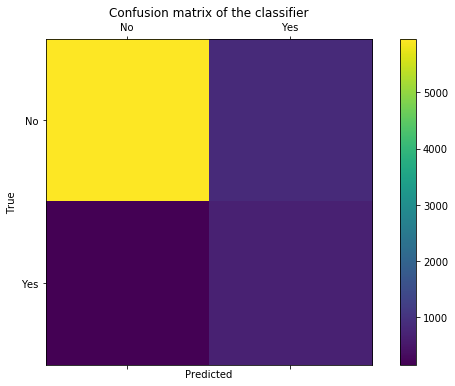

In [61]:
labels = ['No', 'Yes']
cm = confusion_matrix(test_labels, model_xgb_predict)
print(cm)
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

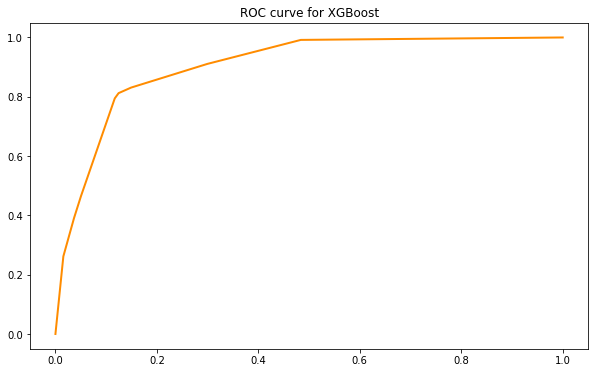

In [62]:
y_score_xgb = model_xgb.predict_proba(test_features)[:,1]

fpr, tpr, threshold = roc_curve(test_labels,y_score_xgb)
auc_score = auc(fpr, tpr)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
             label='micro-AUC = {0:0.2f}'
             ''.format(auc_score))
plt.title('ROC curve for XGBoost')
plt.show()

# Conclusions

### In this research we checked the hypothesis about similarity between probability distributions of two groups of clients. One group of people participated twice, another - once. Those probabilities are likelihood of clients' positive outcome during marketing campaign. From calculated statistical distance we rejected that hypothesis. It means that those groups are different in terms of positive outcome likelihood.  To conduct further analysis we reduced data dimensionality using PCA. We performed K-Means clustering based on 7 principal components, which explain 70% of overall variance in data. We end up with 4 clusters. We focused on conversion rate's analysis and demographic characteristics, which could be attributed to that performance. We identify 3 key segments: most efficient, least efficient and efficient in total numbers of positive outcome (placing deposit). Segment 0 is most efficient segment with positive outcomes more than rejections. Segment 2 is the least efficient segment in terms of relative and absolute performance. Segment 1 contains most part of clients who placed deposits.
### Recommendations
### We suggest that bank should classify new coming clients into obtained clusters. The optimal solution would be focus on segment 0 and segment 2. In addition to this, bank should study clients' social-economic features within each segment. 
### As it stands for now, for segment 0 the ideal client to be targeted would be: blue color worker / manager / technician with 9 years of basic education / university degree / high school, maried or divorced, at the age of 30s or 40s. It is recommended to contact such client no more than 2 times before campaign and no more than two times during campaign. 
### Bank should avoid spending its resources on segment 2, especially on following clients: housmade / services employee / administrative staff with 4 or 6 years of basic education / high school. They are usually older than 35 years old. They did not participate in previous campaign. 
### Bank my also consider working on segment 1 if it wants to increase market share or improve some absolute indicators. Bank should target following clients within this segment: blue color / technician / entrepreneur with 4 or 9 years of basic education / university degree. They are in their 30s or 40s and divorced. Bank should contact them no more than 3 times during marketing campaign.
### Classification
### We also built machine learing models to perform classification task. We chose Balanced Random Forest and XGBoost with weight to account for imbalanced classification problem: number of clients who rejected to place deposit is much higher. XGBoost outperformed Random Forest in terms of general accuracy. But we are more interested in positive class prediction, which random forest performed better than XGBoost. We could also combine those models to obtain better performance for each class.